# **Heatwaves: Assessing the dynamic interactions of the atmosphere and land**

**Content creators:** Sara Shamekh, Ibukun Joyce Ogwu

**Content reviewers:** Ohad Zivan, Douglas Rao

**Content editors:** Zane Mitrevica, Natalie Steinemann, Ohad Zivan, Chi Zhang, Jenna Pearson

**Production editors:** TBD

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

In [1]:
# @title #**Project background** 
#This will be a short video introducing the content creator(s) and motivating the research direction of the template.
#The Tech team will add code to format and display the video

The atmosphere and land are entwined components of the Earth's system, constantly exchanging energy, mass, and momentum. Their interaction contributes to a variety of physical and biological processes. Understanding of the dynamic interactions between atmosphere and land is crucial for predicting and mitigating the impacts of climate change, such as land-use changes and hazards ranging from droughts, floods, and even fluctuation in agricultural production and products ([Jach et. al., 2022](https://esd.copernicus.org/articles/13/109/2022/); [Ogwu et. al. 2018](https://www.researchgate.net/publication/325142745_Economics_of_Soil_Fertility_Management_Practices_in_Nigeria); [Dirmeyer et. al. 2016](https://journals.ametsoc.org/view/journals/bams/99/6/bams-d-17-0001.1.xml)). 

Climate change is also expected to have a significant impact on cereal production around the world. Changes in temperature, precipitation patterns, and extreme weather events can all affect crop yields, as well as the timing and quality of harvests. For example, higher temperatures can lead to reduced yields for crops like wheat and maize, while changes in rainfall patterns can result in droughts or floods that can damage crops or delay planting.

In order to better understand the relationship between climate change and cereal production, researchers have begun to explore the use of environmental monitoring data, including air temperature and soil moisture, to help identify trends and patterns in crop production. By collecting and analyzing this data over time, it may be possible to develop more accurate models and predictions of how climate change will affect cereal production in different regions of the world.

However, it is important to note that while environmental monitoring data can provide valuable insights, there are many other factors that can affect cereal production, including soil quality, pests and diseases, and agricultural practices. Therefore, any efforts to correlate cereal production with climate change must take into account a wide range of factors and be based on robust statistical analyses in order to ensure accurate and reliable results.

**In this project**, you will look into how specific climate variables represent and influence our changing climate. You will combine the effect from various climate variables and use it in models for a more comprehensive understanding of different drivers of heatwave to the influence of land-atmosphere interactions. There will also be an opportunity to relate the aforementioned climate variables to trends in cereal production.

# **Project template**
![template map](https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/projects/template-images/heatwaves_template_map.svg)

# **Data exploration notebook**
## **Project setup**



Please run the following cells!
    



In [2]:
# google colab installs 
# !pip install condacolab      
# import condacolab
# condacolab.install()

In [2]:
# !mamba install xarray-datatree intake intake-esm gcsfs xmip aiohttp cartopy nc-time-axis cf_xarray xarrayutils "esmf<=8.3.1" xesmf 

In [16]:
# imports
import time
tic = time.time()

import pandas as pd
import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

import cartopy.crs as ccrs
import random
import pooch


In [10]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}
%matplotlib inline


## **CMIP6: near surface temperature**

The CMIP6 dataset will be utilized to examine temperature trends and heatwaves. Specifically, we will be focusing on near-surface temperature, which refers to the air temperature at the Earth's surface. In this study, we will be analyzing data from one model and examining its historical temperature records. However, we encourage students to explore other models and investigate intermodel variability, as they have learned to do during their exploration of the CMIP dataset.

After selecting our model, we will plot the near-surface air temperature for the entire globe.

In [17]:
# loading CMIP data 

col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# There are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ['MPI-ESM1-2-LR']

In [18]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id='tas',
    member_id='r1i1p1f1',
    table_id='3hr',
    grid_label='gn',
    experiment_id = ['historical'],# add scenarios if interested in projection
    require_all_on = ['source_id'] #make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(**kwargs)
dt


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


DataTree('None', parent=None)
└── DataTree('MPI-ESM1-2-LR')
    └── DataTree('historical')
            Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 482120, y: 96,
                                 x: 192, bnds: 2, vertex: 4)
            Coordinates:
                height          float64 2.0
              * y               (y) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
              * x               (x) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
              * time            (time) object 1850-01-01 03:00:00 ... 2015-01-01 00:00:00
                lon_bounds      (x, bnds, y) float64 dask.array<chunksize=(192, 2, 96), meta=np.ndarray>
                lat_bounds      (y, bnds, x) float64 dask.array<chunksize=(96, 2, 192), meta=np.ndarray>
                lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.1 358.1 358.1
                lat             (x, y) float64 -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
                lon_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 192, 96), meta=np.ndarray>
                lat_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 192, 96), meta=np.ndarray>
              * member_id       (member_id) object 'r1i1p1f1'
              * dcpp_init_year  (dcpp_init_year) float64 nan
            Dimensions without coordinates: bnds, vertex
            Data variables:
                tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 1456, 96, 192), meta=np.ndarray>
            Attributes: (12/63)
                Conventions:                      CF-1.7 CMIP-6.2
                activity_id:                      CMIP
                branch_method:                    standard
                branch_time_in_child:             0.0
                branch_time_in_parent:            0.0
                cmor_version:                     3.5.0
                ...                               ...
                intake_esm_attrs:variable_id:     tas
                intake_esm_attrs:grid_label:      gn
                intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-...
                intake_esm_attrs:version:         20190710
                intake_esm_attrs:_data_format_:   zarr
                intake_esm_dataset_key:           MPI-ESM1-2-LR/historical

In [9]:
# select just a single model and experiment
tas_historical= dt['MPI-ESM1-2-LR']['historical'].ds.tas
print('The time range is:')
print( tas_historical.time[0].data.astype('M8[h]') , 'to', tas_historical.time[-1].data.astype('M8[h]') )

The time range is:
1850-01-01T03 to 2015-01-01T00


Now it's time to plot the data. For this initial analysis, we will focus on a specific date and time. As you may have noticed, we are using 3-hourly data, which allows us to also examine the diurnal and seasonal cycles. It would be fascinating to explore how the amplitude of the diurnal and seasonal cycles varies with region and latitude. You can do it later!

Text(0.5, 1.0, 'July, 1st 2013')

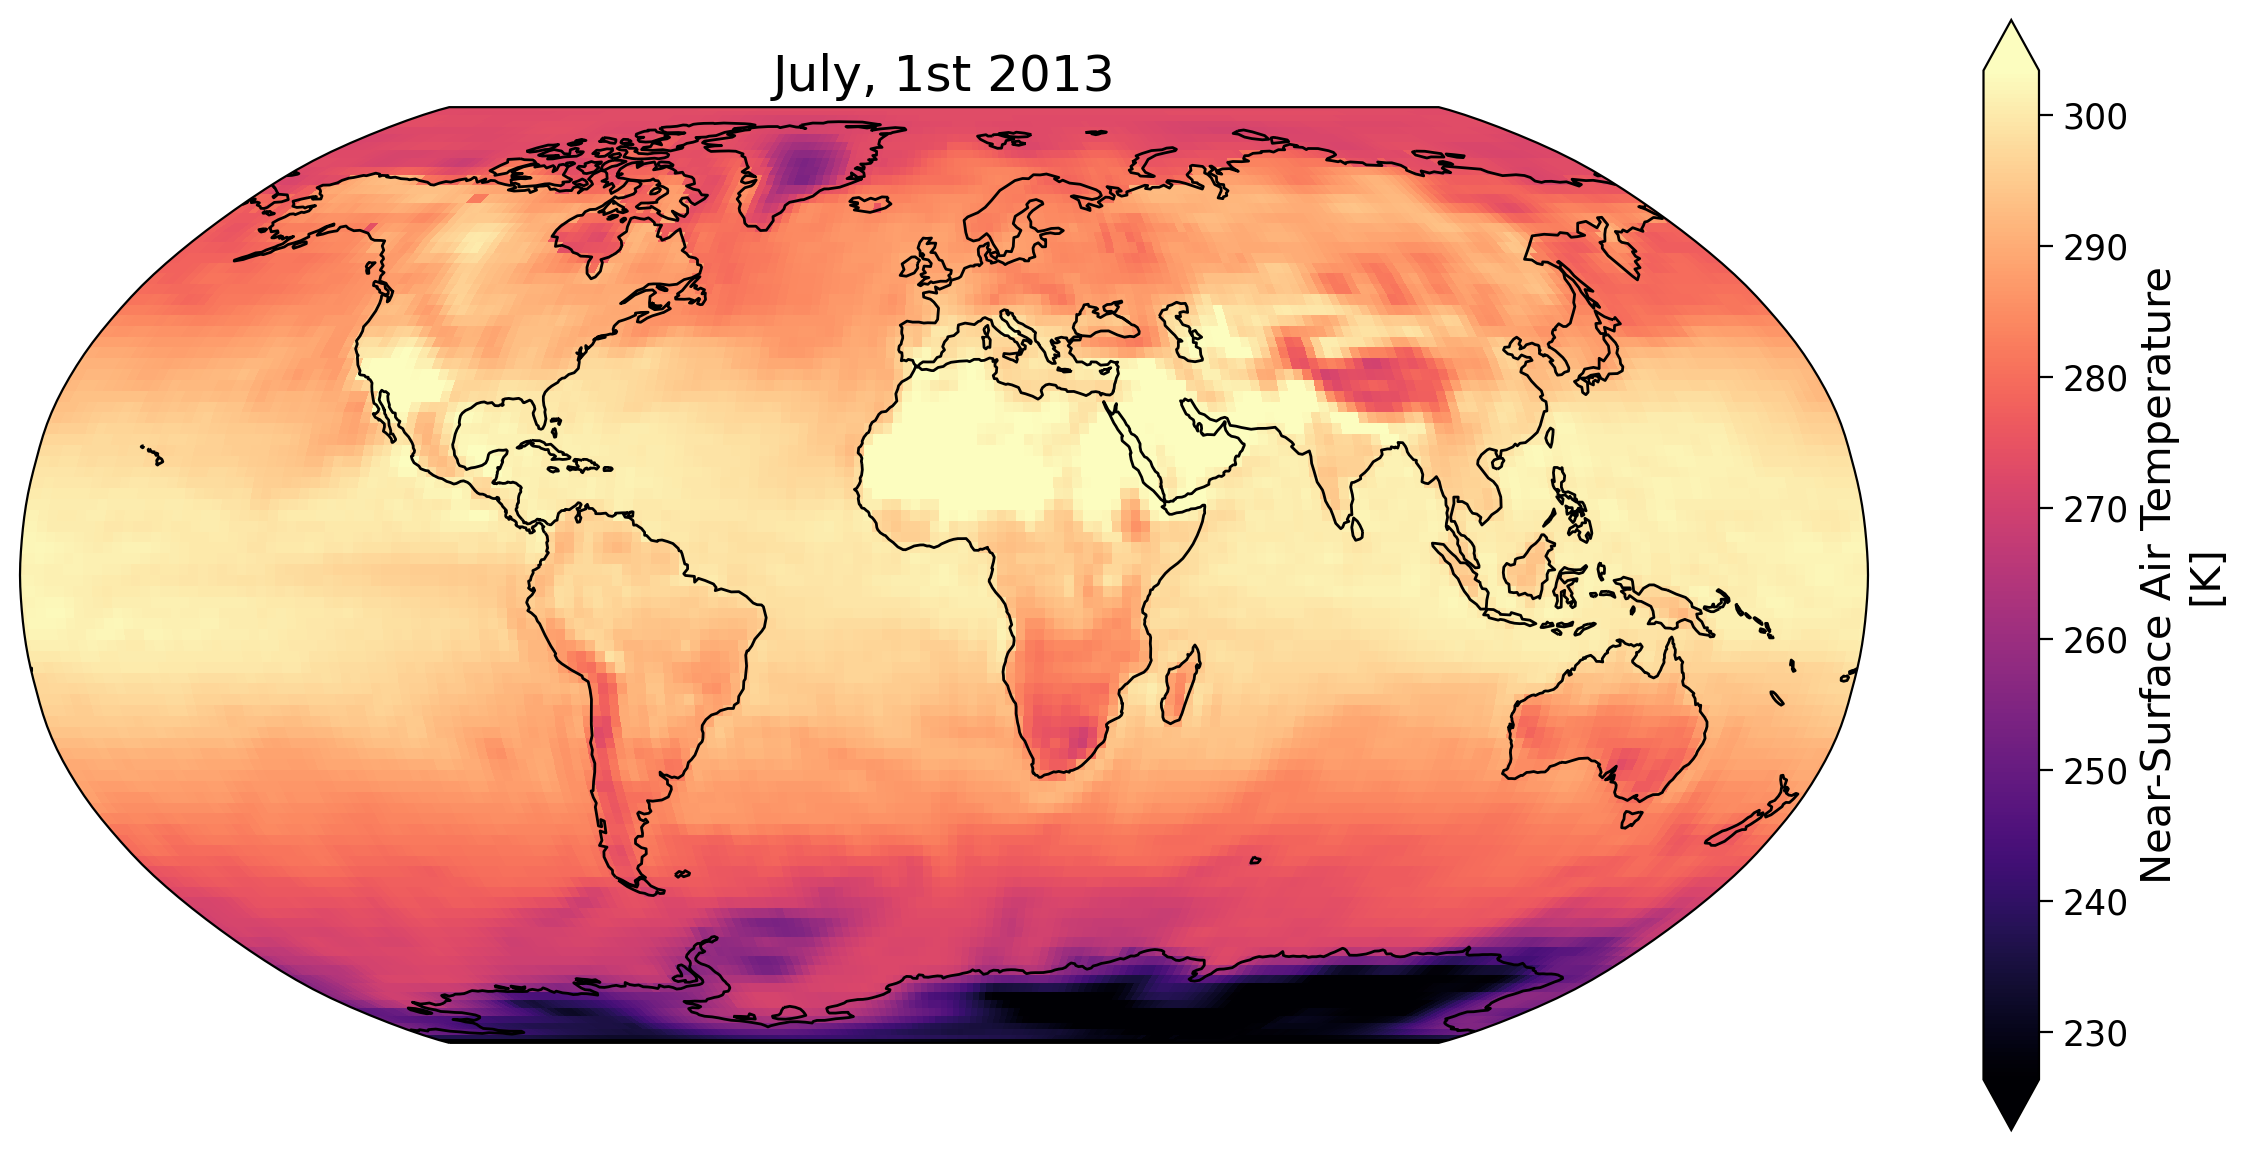

In [11]:
fig, ax_present = plt.subplots(
    figsize=[12,6],
    subplot_kw={'projection':ccrs.Robinson()}
)

# plot a timestep for 2020
tas_present = tas_historical.sel(time='2013-07-01T00').squeeze()
tas_present.plot(ax=ax_present, transform=ccrs.PlateCarree(), cmap='magma', robust=True)
ax_present.coastlines()
ax_present.set_title('July, 1st 2013')

### **CMIP6: precipitation and soil moisture (optional)**

In addition to examining temperature trends, you can also load precipitation data or variables related to soil moisture. This is an optional exploration, but if you choose to do so, you can load regional precipitation data at the same time and explore how these two variables are related when analyzing regional temperature trends. This can provide insights into how changes in temperature and precipitation may be affecting the local environment.

to learn more about covariability of temperature and moisture, you can have a look at [this](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021GL097697) or [this](https://www.nature.com/articles/s41586-021-03325-5) paper. The relationship between soil moisture, vegetation, and temperature is an active field of research. 

### **Q7: heatwave detection**

Question 7 asks you to detect heatwave. Below you can see a flowchart for detecting heatwaves. The flowchart includes three paramteres that you need to set in adavance. These three parameters are the window (numpber of days) over which you detect the extereme (95 percentile) of temperature, the duration of heatwave and its spatial extention.
![picture](https://raw.githubusercontent.com/Sshamekh/Heatwave/e7ae59ac394b0a9a040bcc4f58009ab478a3daa8/Heat_wave_detection_flewchart.jpg)


for Question 12, read the following [article](https://www.nature.com/articles/s41467-022-31432-y.pdf)

for Question 13, read the following articles: [article 1](https://agupubs.onlinelibrary.wiley.com/doi/pdfdirect/10.1029/2023GL103405), and [article 2](https://www.frontiersin.org/articles/10.3389/fclim.2022.789641/full)

## **World bank data: Cereal production and land under cereal production**

Cereal production is a crucial component of global agriculture and food security. The World Bank collects and provides data on cereal production, which includes crops such as wheat, rice, maize, barley, oats, rye, sorghum, millet, and mixed grains. The data covers various indicators such as production quantity, area harvested, yield, and production value.

The World Bank also collects data on land under cereals production, which refers to the area of land that is being used to grow cereal crops. This information can be valuable for assessing the productivity and efficiency of cereal production systems in different regions, as well as identifying potential areas for improvement. Overall, the World Bank's data on cereal production and land under cereals production is an important resource for policymakers, researchers, and other stakeholders who are interested in understanding global trends in agriculture and food security.

In [13]:
# Code to retrieve and load the data
rrl_cereal = 'https://raw.githubusercontent.com/Sshamekh/Heatwave/f85f43997e3d6ae61e5d729bf77cfcc188fbf2fd/data_cereal_land.csv'
ds_cereal_land = pd.read_csv(pooch.retrieve(rrl_cereal, known_hash=None))
ds_cereal_land.head() 

SHA256 hash of downloaded file: 0d71645aeeb9e1cca8abe179c525c496f3b2b02867119069679762c0f9f1da47
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


,Country Name,Country Code,Series Name,Series Code,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,Afghanistan,AFG,Cereal production (metric tons),AG.PRD.CREL.MT,3950000,4270000,4351000,4481000,4624000,4147000,...,6379000,6520329,6748023.28,5808288,5532695.42,4892953.97,4133051.85,5583461,6025977,4663880.79
1,Afghanistan,AFG,Land under cereal production (hectares),AG.LND.CREL.HA,3923100,3337000,3342000,3404000,3394000,3388000,...,3143000,3182922,3344733,2724070,2793694,2419213,1911652,2641911,3043589,2164537
2,Albania,ALB,Cereal production (metric tons),AG.PRD.CREL.MT,585830,625498,646200,666500,857000,910400,...,697400,702870,700370,695000,698430,701734,678196,666065,684023,691126.7
3,Albania,ALB,Land under cereal production (hectares),AG.LND.CREL.HA,331220,339400,334040,328500,350500,357000,...,142800,142000,143149,142600,148084,145799,140110,132203,131310,134337
4,Algeria,DZA,Cereal production (metric tons),AG.PRD.CREL.MT,2362625,1595994,1480275,2680452,2313186,1142509,...,5137455,4912551,3435535,3761229.6,3445227.37,3478175.14,6066252.82,5633596.78,4393336.75,2784017.29


### **Q9: correlation**
For Question 9 you need to compute the correlation between two variables. You can use Pearson's correlation coefficient to evaluate the correlation between two variables. You can read about Pearsons correlation coefficient [on Wikipedia](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and from [Scipy python library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html). You are also encouraged to plot the scatter plot between two variables to visually see their correlation. 

### **Q12: linear regression**
For question 12 you need to build the regession model. You can read abut regression model [on Wikipedia](https://en.wikipedia.org/wiki/Simple_linear_regression) and from [Scipy python library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).

# **Further reading**

- Dirmeyer, P. A., Gochis, D. J., & Schultz, D. M. (2016). Land-atmosphere interactions: the LoCo perspective. Bulletin of the American Meteorological Society, 97(5), 753-771.

- Ogwu I. J., Omotesho, O. A. and Muhammad-Lawal, A., (2018) Chapter 11: Economics of Soil Fertility Management Practices in Nigeria in the book by Obayelu, A. E. ‘Food Systems Sustainability and Environmental Policies in Modern Economies’ (pp. 1-371).Hershey, PA: IGI Global. doi:10.4018/978-1-5225-3631-4 

- Jach, L., Schwitalla, T., Branch, O., Warrach-Sagi, K., and Wulfmeyer, V. (2022) Sensitivity of land–atmosphere coupling strength to changing atmospheric temperature and moisture over Europe, Earth Syst. Dynam., 13, 109–132, https://doi.org/10.5194/esd-13-109-2022
